In [9]:
import phasr as phr

In [10]:
phr.__version__

'0.1.dev296+g8bec85100.d20251125'

In [11]:
import numpy as np
pi=np.pi
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
from IPython.display import display, Math

In [13]:
def print_radius(charge_dict,manual_digits_offset=0):
    redchisq=charge_dict['redchisq']
    
    r_ch=charge_dict['r_ch']
    
    dr=charge_dict['dr_ch_stat']*np.sqrt(redchisq)
    dr_s=charge_dict['dr_ch_syst']
    dr_m=charge_dict['dr_ch_model']
    dr_u=charge_dict['dr_ch_syst_upper']
    dr_l=charge_dict['dr_ch_syst_lower']
    dr_d=charge_dict['dr_ch_dist']
    dr_d_u=charge_dict['dr_ch_dist_upper']
    dr_d_l=charge_dict['dr_ch_dist_lower']
    dr_dm=np.sqrt(dr**2+dr_d**2)
    
    digs_r=int(-np.log10(dr))+2
    
    while np.max([dr,dr_s,dr_m])*10**digs_r>69: 
        digs_r-=1
    while np.max([dr,dr_s,dr_m])*10**digs_r<3.1:
        digs_r+=1

    digs_r+=manual_digits_offset
    
    s=r'\sqrt{\langle r^2 \rangle} = '+r'{r_ch:1.{digs_r}f}({dr:1d})'.format(r_ch=r_ch,digs_r=digs_r,dr=int(np.round(dr*10**digs_r,0)))+r'\begin{matrix}'+r'({dr_s:1d}) [{dr_m:1d}] \\ ( +{dr_d_u:1d}/-{dr_d_l:1d} ) [{dr_dm:1d}]'.format(dr_s=int(np.round(dr_s*10**digs_r,0)),dr_m=int(np.round(dr_m*10**digs_r,0)),dr_d_u=int(np.round(dr_d_u*10**digs_r,0)),dr_d_l=int(np.round(dr_d_l*10**digs_r,0)),dr_dm=int(np.round(dr_dm*10**digs_r,0)))+r'\end{matrix}'
    display(Math(s))

# Import data

## Cross section Data

In [14]:
path_Xe132_Sc18 = "./Scrit_Xe132_2018.txt"
Z=54
A=132

In [15]:
#How to anser the questions: 
#What column (starting at 0) contains the central values for the energie? 0
#In what units is the energy (MeV or GeV)? MeV
#What column (starting at 0) contains the central values for the angles? 1
#In what units is the angle theta (deg or rad)? rad
#Do the cross sections need to be fitted with a free luminosity parameter for each energy? (y or n) y
#What column (starting at 0) contains the energies for the cross section*luminosity points? 2
#In what units is the cross section*luminosity (1/s,1/ms,1/micros)? 1/s
#Does the data distinguish between statistical and systematical uncertainties? (y or n) y
#What columns (starting at 0), if any, contain statistical uncertainties for the cross sections (separate by comma)? 3
#Are the statistical uncertainties absolute values or relative to the central value? (answer with: absolute or relative) relative
#Are the relative statistical uncertainties in percent and thus need to divided by 100? (y or n) y
#What columns (starting at 0), if any, contain systematical uncertainties for the cross sections (separate by comma)? skip
#Are the systematical uncertainties absolute values or relative to the central value? (answer with: absolute or relative) skip
#Are the relative systematical uncertainties in percent and thus need to divided by 100? (y or n) y
#Do you want to add a global relative statistical uncertainty w.r.t. the cross section as an (additional) uncertainty component? (For 3% insert 3, type 0 if you do not want to do so)? 0
#Do you want to add a global relative systematical uncertainty w.r.t. the cross section as an (additional) uncertainty component? (For 3% insert 3, type 0 if you do not want to do so)? 5

In [16]:
data_type=phr.import_dataset(path_Xe132_Sc18,"Scrit_2018",Z,A)

reaction_rate_data saved in  ./data/cross_section_data/reaction_rate_Scrit_2018_Z54_A132.txt
reaction_rate_statistical correlation data saved in  ./data/cross_section_data/reaction_rate_Scrit_2018_Z54_A132_correlation_stat.txt
reaction_rate_systematical correlation data saved in  ./data/cross_section_data/reaction_rate_Scrit_2018_Z54_A132_correlation_syst.txt
The dataset Scrit_2018_Z54_A132 can now be accessed by the fitting routines


### Compare Data to reference parameterization

In [18]:
# Comparison extraction from dVries et al. 1987
nuc_Ar40_ref = phr.nuclei.load_reference_nucleus(Z,A)
nuc_Ar40_ref

KeyError: 'No parameterisation on file for this isotope'

In [17]:
data_Ar40, corr_stat_Ar40, corr_syst_Ar40 = phr.cross_section_fitter.data_prepper.load_dataset("Scrit_2018",Z,A,data_type)

cross section data loaded from  ./data/cross_section_data/reaction_rate_Scrit_2018_Z54_A132.txt
cross section statistical correlation data loaded from  ./data/cross_section_data/reaction_rate_Scrit_2018_Z54_A132_correlation_stat.txt
cross section systematical correlation data loaded from  ./data/cross_section_data/reaction_rate_Scrit_2018_Z54_A132_correlation_syst.txt


In [11]:
args_optimised =  {'method': 'DOP853',
 'N_partial_waves': 25,
 'atol': 1e-08,
 'rtol': 1e-06,
 'energy_norm': 0.001973269804,
 'phase_difference_limit': 1e-06}

In [12]:
theta=np.arange(25,100,1)*pi/180
CS={}
for E in np.unique(data_Ar40[:,0]):
    CS[E]=phr.crosssection_lepton_nucleus_scattering(E,theta,nuc_Ar40_ref,**args_optimised)*phr.constants.hc**2

Text(0, 0.5, 'cross section in fm$^{2}$/sr')

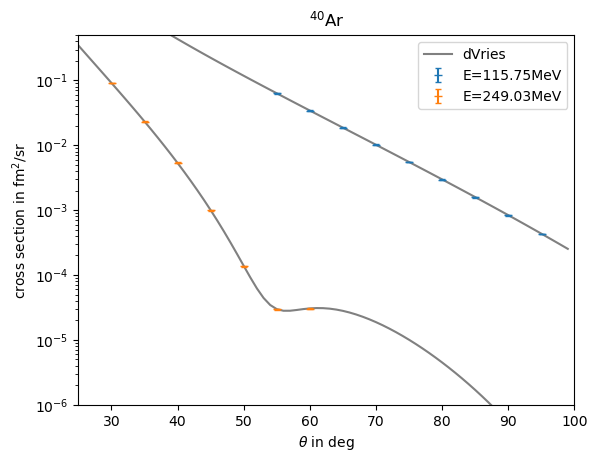

In [13]:
for E in np.unique(data_Ar40[:,0]):
    mask = data_Ar40[:,0]==E
    plt.errorbar(data_Ar40[mask,1]*180/pi,data_Ar40[mask,2],np.sqrt(data_Ar40[mask,3]**2+data_Ar40[mask,4]**2),capsize=2,marker='_',linestyle='',label='E='+str(E)+'MeV')
first = True
for E in np.unique(data_Ar40[:,0]):
    plt.plot(theta*180/pi,CS[E],color='gray',zorder=-2,label='dVries' if first else None)
    first=False
plt.yscale('log')
plt.legend()
plt.xlim(25,100)
plt.ylim(1e-6,5e-1)
plt.title(r'$^{40}$Ar')
plt.xlabel(r'$\theta$ in deg')
plt.ylabel(r'cross section in fm$^{2}$/sr')

## Barrett Moment

In [14]:
path_example = "./Fricke1995_barrett_moments.txt"

with open( path_example, "rb" ) as file:
    barrett_moments_input = np.genfromtxt( file,dtype=[r'<U3',int,int,r'<U10']+9*[float],names=['Symbol','Z','A','transition','E_tran','dE_tran','N_pol','alpha','k','C_z','barrett','dbarrett_stat','dbarrett_pol'])

pd.DataFrame(barrett_moments_input)

,Symbol,Z,A,transition,E_tran,dE_tran,N_pol,alpha,k,C_z,barrett,dbarrett_stat,dbarrett_pol
0,Be,4,9,2p->1s,33.4020,0.0100,0.0010,0.0420,2.1160,-20.800,5.6613,0.7697,0.0222
1,B,5,-1,2p->1s,52.2570,0.0070,0.0010,0.0440,2.1190,-8.600,5.9557,0.2277,0.0113
2,C,6,12,2p->1s,75.2582,0.0005,0.0025,0.0208,2.0231,-4.141,5.9419,0.0077,0.0121
3,C,6,13,2p->1s,75.3127,0.0040,0.0025,0.0208,2.0231,-4.135,5.9313,0.0602,0.0113
4,C,6,14,2p->1s,75.3514,0.0030,0.0025,0.0208,2.0234,-4.095,6.0453,0.0453,0.0107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,Pb,82,207,2p32->1s,5968.8640,0.2100,2.3040,0.1486,2.3035,-1.402,21.1688,0.0013,0.0044
327,Pb,82,208,2p12->1s,5778.0580,0.1000,2.9450,0.1507,2.3076,-1.474,21.0982,0.0009,0.0056
328,Pb,82,208,2p32->1s,5962.8540,0.0900,2.7180,0.1485,2.3037,-1.404,21.2294,0.0004,0.0048
329,Bi,83,209,2p12->1s,5843.2000,0.0025,3.8440,0.1540,2.3290,-1.458,21.5694,0.0158,0.0079


In [15]:
barrett_moment_Ar40 = barrett_moments_input[np.logical_and(barrett_moments_input['Z']==18,barrett_moments_input['A']==40)]
barrett_moment_Ar40_dict = {key:barrett_moment_Ar40[key][0] for key in  ['Z','A','k','alpha','barrett']}
barrett_moment_Ar40_dict['dbarrett'] = np.sqrt(barrett_moment_Ar40['dbarrett_stat'][0]**2 + barrett_moment_Ar40['dbarrett_pol'][0]**2)

In [16]:
barrett_moment_Ar40_dict

{'Z': np.int64(18),
 'A': np.int64(40),
 'k': np.float64(2.0827),
 'alpha': np.float64(0.0546),
 'barrett': np.float64(10.5669),
 'dbarrett': np.float64(0.012425779653607253)}

In [17]:
phr.cross_section_fitter.data_prepper.import_barrett_moment("Fricke1995_2p",**barrett_moment_Ar40_dict)

barrett moment value saved in  ./data/barrett_moment_data/barrett_moment_Fricke1995_2p_Z18_A40.txt
The barrett moment value with label Fricke1995_2p_Z18_A40 can now be accessed by the fitting routines


# Base fits

In [18]:
# Check available datasets

In [19]:
phr.cross_section_fitter.data_prepper.list_datasets(18,40)

These loaded datasets were found for Z=18 and A=40:
['Ottermann1982']


In [20]:
phr.cross_section_fitter.data_prepper.list_barrett_moments(18,40)

These loaded datasets were found for Z=18 and A=40:
['Fricke1995_2p']


In [21]:
args_optimised =  {'method': 'DOP853',
 'N_partial_waves': 25,
 'atol': 1e-08,
 'rtol': 1e-06,
 'energy_norm': 0.001973269804,
 'phase_difference_limit': 1e-06}

In [22]:
results_dict = phr.cross_section_fitter.fit_organizer.parallel_fitting_automatic(['Ottermann1982'],18,40,np.arange(4.00,8.75+0.25,0.25),redo_N=True,redo_aggressive=True,N_base_offset=1,N_base_span=3,cross_section_args=args_optimised)

Queuing 102 tasks, which will be performed over 6 processes.
Finished all tasks.
Check if any fits need to be redone.
For R5.75_N6 chi^2 with 1 less parameter is more than 1 permil better: 11.912001534760861 vs 11.057261857466806
For R6.25_N6 chi^2 with 1 less parameter is more than 1 permil better: 5754.768161487707 vs 10.603547808331065
For R6.25_N7 chi^2 with 2 less parameter is more than 1 permil better: 5498.120770905572 vs 10.603547808331065
For R7.0_N5 chi^2 with 1 less parameter is more than 1 permil better: 11.061470900571166 vs 10.518139977078762
For R7.75_N7 chi^2 with 1 less parameter is more than 1 permil better: 12.249547656658462 vs 10.331939288014729
For R7.75_N8 chi^2 with 2 less parameter is more than 1 permil better: 17.570650580719906 vs 10.331939288014729
For R8.0_N7 chi^2 with 1 less parameter is more than 1 permil better: 25096.71250870271 vs 10.322012751932105
For R8.0_N8 chi^2 with 2 less parameter is more than 1 permil better: 25998.625201169616 vs 10.32201275

In [23]:
database_tables, Rs, Ns, hist = phr.cross_section_fitter.generate_data_tables(results_dict)

In [24]:
pd.DataFrame(database_tables['p_val'],index=Rs,columns=Ns)

,3.0,4.0,5.0,6.0,7.0,8.0
4.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
4.25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
4.50,0.000000e+00,3.839800e-235,2.040613e-180,1.431578e-149,NaN,NaN
4.75,3.472725e-201,2.432609e-106,3.580043e-61,2.447410e-39,NaN,NaN
5.00,6.732223e-113,4.407200e-30,2.982187e-06,3.480082e-02,0.033821,NaN
5.25,8.065356e-58,3.594259e-02,1.585879e-01,1.491464e-01,0.128603,NaN
5.50,3.742389e-27,3.450933e-01,3.928475e-01,3.950161e-01,0.349871,NaN
5.75,1.127148e-12,4.910698e-01,5.240178e-01,4.384610e-01,0.377546,NaN
6.00,1.685241e-07,5.746593e-01,5.539131e-01,4.752856e-01,0.389338,NaN
6.25,8.635175e-08,6.150074e-01,5.631648e-01,4.770553e-01,0.389232,NaN


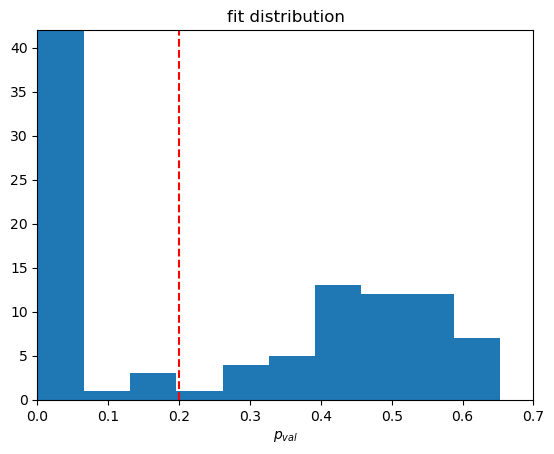

In [25]:
plt.title('fit distribution')
plt.xlabel(r'$p_{val}$')
plt.plot([0.2,0.2],[0,42],color='red',linestyle='--')
plt.ylim(0,42)
plt.xlim(0,0.7)
plt.hist(hist['p_val'],10)
plt.show()

In [26]:
selected_RN_tuples = phr.cross_section_fitter.fit_organizer.select_RN_based_on_property(results_dict,'p_val',0.2)

In [27]:
len(selected_RN_tuples)

54

# Final fits (with barrett moments)

In [28]:
ini_settings = {'datasets':['Ottermann1982'],'datasets_barrett_moment':[],'monotonous_decrease_precision':np.inf}

In [29]:
results_dict_bar = phr.cross_section_fitter.fit_organizer.parallel_fitting_manual(['Ottermann1982'],18,40,selected_RN_tuples,redo_N=True,monotonous_decrease_precision=0.04,barrett_moment_keys=['Fricke1995_2p'],initialize_from=ini_settings,cross_section_args=args_optimised)

Queuing 54 tasks, which will be performed over 6 processes.
Finished all tasks.
Check if any fits need to be redone.
For R5.5_N7 chi^2 with 1 less parameter is more than 1 permil better: 75.02441442179081 vs 73.61641710888675
For R5.75_N6 chi^2 with 1 less parameter is more than 1 permil better: 44.347673437528115 vs 36.51010900429935
For R6.25_N7 chi^2 with 1 less parameter is more than 1 permil better: 12.922886655763117 vs 12.696373836355729
For R6.5_N6 chi^2 with 1 less parameter is more than 1 permil better: 12.331999506437977 vs 11.468277928173462
For R6.5_N7 chi^2 with 1 less parameter is more than 1 permil better: 17.757075748062874 vs 12.331999506437977
For R6.75_N6 chi^2 with 1 less parameter is more than 1 permil better: 11.684659575964368 vs 11.214757327616265
For R7.0_N6 chi^2 with 1 less parameter is more than 1 permil better: 12.337214998448282 vs 11.038493441175275
For R7.75_N8 chi^2 with 1 less parameter is more than 1 permil better: 13.441983755261631 vs 10.6493153405

In [30]:
database_tables_bar, Rs, Ns, hist_bar = phr.cross_section_fitter.generate_data_tables(results_dict_bar)

In [31]:
pd.DataFrame(database_tables_bar['p_val'],index=Rs,columns=Ns)

,4.0,5.0,6.0,7.0,8.0
5.50,8.017157e-11,4.808544e-11,1.721447e-10,6.711495e-11,NaN
5.75,2.421712e-05,8.747311e-04,1.646052e-03,2.528833e-04,NaN
6.00,6.082790e-03,1.044867e-01,1.379875e-01,1.018921e-01,NaN
6.25,7.174326e-02,4.994539e-01,4.715287e-01,3.914915e-01,NaN
6.50,2.188445e-01,6.489206e-01,5.716606e-01,4.196954e-01,NaN
6.75,3.752092e-01,6.690887e-01,5.928473e-01,5.170287e-01,NaN
7.00,5.211162e-01,6.830094e-01,6.072461e-01,5.298765e-01,NaN
7.25,6.565510e-01,6.948840e-01,6.196082e-01,5.422715e-01,NaN
7.50,7.559025e-01,7.031373e-01,6.284819e-01,5.518281e-01,0.465547
7.75,3.602158e-01,7.092284e-01,6.362129e-01,5.591871e-01,0.473111


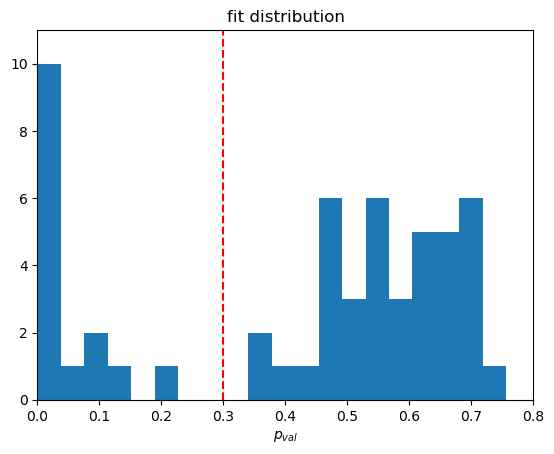

In [32]:
plt.title('fit distribution')
plt.xlabel(r'$p_{val}$')
plt.ylim(0,11)
plt.xlim(0,0.8)
plt.plot([0.3,0.3],[0,42],color='red',linestyle='--')
plt.hist(hist_bar['p_val'],20)
plt.show()

In [33]:
qs=[50,235,370,600]
results_dict_bar_sel, results_dict_bar_veto, veto_fct = phr.cross_section_fitter.fit_organizer.split_based_on_asymptotic_and_p_val(results_dict_bar,qs=qs,p_val_lim=0.3)

Asymptotic Parameter: m=4


In [34]:
# check asymptotics choice

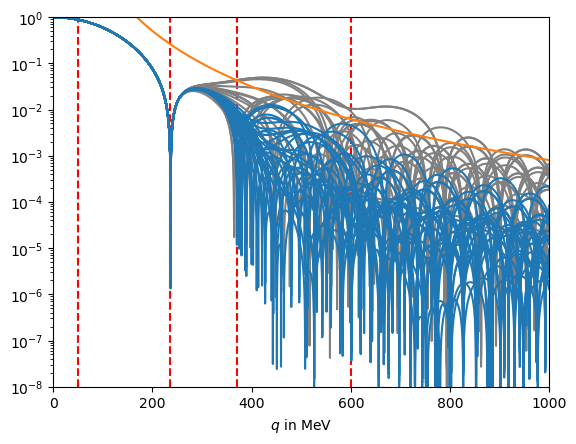

In [35]:
q = np.arange(1e-1,1000,1e-1)
for key in results_dict_bar_sel:
    result=results_dict_bar_sel[key]
    nuc_result = phr.nucleus('Ar40_FB_test_'+key,18,40,ai=result['ai'],R=result['R'])
    plt.plot(q,np.abs(nuc_result.form_factor(q)),color='C0',zorder=1)
for key in results_dict_bar_veto:
    result=results_dict_bar_veto[key]
    nuc_result = phr.nucleus('Ar40_FB_test_'+key,18,40,ai=result['ai'],R=result['R'])
    plt.plot(q,np.abs(nuc_result.form_factor(q)),color='gray',zorder=-3)
for qi in qs:
    plt.plot([qi,qi],[1e-8,1e0],color='red',zorder=-5,linestyle='--')
plt.plot(q,veto_fct(q),color='C1')
plt.xlim(0,1000)
plt.ylim(1e-8,1e0)
plt.xlabel('form factor')
plt.xlabel('$q$ in MeV')
plt.yscale('log')

In [36]:
# select best result
best_key_bar = None
best_p_val = 0
for key in results_dict_bar_sel:
    p_val = results_dict_bar_sel[key]['p_val']
    if p_val > best_p_val:
        best_p_val = p_val
        best_key_bar = key
best_key_bar, best_p_val

('R7.5_N4', np.float64(0.7559024546771846))

In [37]:
phr.cross_section_fitter.pickler.promote_best_fit(best_key_bar,results_dict_bar_sel)

Saving best result to ./data/best_fits/best_fit_result_Z18_A40.pkl
Saving results for systematics to ./data/best_fits/best_fit_result_Z18_A40_systematics


In [38]:
best_results_dict_bar = phr.cross_section_fitter.uncertainties.add_systematic_uncertainties(best_key_bar,results_dict_bar_sel)

In [39]:
best_nuc_result = phr.nucleus('Ar40_FB_best_test',18,40,ai=best_results_dict_bar['ai'],R=best_results_dict_bar['R'])
best_cov_ai_model = best_results_dict_bar['cov_ai_model']
best_cov_ai_stat = best_results_dict_bar['cov_ai_stat'] * np.sqrt(best_results_dict_bar['redchisq'])
best_cov_ai_syst = best_results_dict_bar['cov_ai_syst']

Text(0, 0.5, '$\\rho$ in fm$^{-3}$')

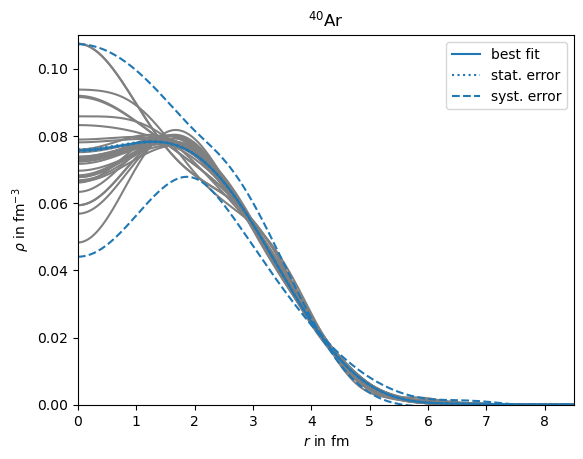

In [40]:
r = np.arange(0,15,1e-2)
best_rho = best_nuc_result.charge_density(r)
plt.plot(r,best_rho,color='C0',zorder=2,label='best fit')
best_jac_rho = best_nuc_result.charge_density_jacobian(r)
best_drho_model = np.sqrt(np.einsum('ij,ik,kj->j',best_jac_rho,best_cov_ai_model,best_jac_rho))
best_drho_stat = np.sqrt(np.einsum('ij,ik,kj->j',best_jac_rho,best_cov_ai_stat,best_jac_rho))
best_drho_syst = np.sqrt(np.einsum('ij,ik,kj->j',best_jac_rho,best_cov_ai_syst,best_jac_rho))
plt.plot(r,best_rho+best_drho_stat,color='C0',linestyle=':',zorder=1,label='stat. error')
plt.plot(r,best_rho-best_drho_stat,color='C0',linestyle=':',zorder=1)
plt.plot(r,best_rho+best_drho_syst,color='C0',linestyle='--',zorder=1,label='syst. error')
plt.plot(r,best_rho-best_drho_syst,color='C0',linestyle='--',zorder=1)
for key in results_dict_bar_sel:
    result=results_dict_bar_sel[key]
    nuc_result = phr.nucleus('Ar40_FB_test_'+key,18,40,ai=result['ai'],R=result['R'])
    plt.plot(r,nuc_result.charge_density(r),color='gray',zorder=-2) #,label=key
#plt.plot(r,nuc_Ar40_ref.charge_density(r),color='C1',zorder=-1,label=nuc_Ar40_ref.name)
plt.xlim(0,8.5)
plt.ylim(0,0.11)
plt.legend()
plt.title('$^{40}$Ar')
plt.xlabel('$r$ in fm')
plt.ylabel(r'$\rho$ in fm$^{-3}$')
#plt.yscale('log')

In [41]:
print_radius(best_results_dict_bar,+1)

<IPython.core.display.Math object>